In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 50)

In [19]:
## -------------- Load data --------------------
loan_data = [pd.read_csv(f'https://github.com/minh221/AAU_MSc_BDS/raw/main/m1/data/kiva_data_{i}.zip') for i in [1,2]]
iso = pd.read_csv('https://raw.githubusercontent.com/minh221/AAU_MSc_BDS/main/m1/data/iso_3166.csv')
mpi = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv')
## concat all parts of kiva_loan_data
df = pd.concat(loan_data)

## ------------- Clean loan data ----------------
df = df.dropna(subset=['loan_amount', 'term_in_months', 'lender_count', 'repayment_interval'])
## calculate time for a loan to be fully funded
date_cols = ['disbursed_time', 'funded_time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
df['days_fully_funded'] = (df['funded_time'] - df['disbursed_time']) / np.timedelta64(1, 'D')
## remove outliers
Q1 = np.percentile(df['loan_amount'], 25, method='midpoint')
Q3 = np.percentile(df['loan_amount'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
df = df[(df['loan_amount'] < upper) & (df['loan_amount'] > lower)]

## ---------------- Select the nessasary columns ---------------
data = df.rename(columns={'country_code':'alpha-2'})
iso = iso[['name', 'alpha-2', 'alpha-3']].rename(columns={'name':'country'})
mpi = mpi[['ISO','region', 'MPI']].dropna().drop_duplicates().rename(columns={'ISO':'alpha-3', 'MPI':'mpi_value'})
## mpi table does not have standard region name, and also the region name in loan data is not unanimous, so hard to map because there are so many exceptions
## therefore, using avg mpi by country
mpi_country = mpi.groupby('alpha-3')['mpi_value'].mean().reset_index() 

## ----------------- Join ----------------
data = data.merge(iso, on='alpha-2')
data = data.merge(mpi_country, on='alpha-3')
data = data[['id', 'activity', 'sector', 'loan_amount', 'term_in_months', 'lender_count', 'days_fully_funded', 'repayment_interval','mpi_value' ]]
data = data.dropna().reset_index()
len(data)

518285

OneHotEncoder & StandardScaler & TruncatedSVD

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
oh_encoder = OneHotEncoder(sparse_output=False)
categorical_cols = ['repayment_interval']
one_hot_encoded = oh_encoder.fit_transform(data[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=oh_encoder.get_feature_names_out(categorical_cols))
data_one_hot = pd.concat([data, one_hot_df], axis=1).drop(columns=categorical_cols)
data_one_hot.head(2)


,index,id,activity,sector,loan_amount,term_in_months,lender_count,days_fully_funded,mpi_value,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,0,653051,Fruits & Vegetables,Food,300.0,12.0,12,16.087870,0.233167,0.0,1.0,0.0,0.0
1,1,653053,Rickshaw,Transportation,575.0,11.0,14,16.053738,0.233167,0.0,1.0,0.0,0.0


In [21]:
data_one_hot.columns

Index(['index', 'id', 'activity', 'sector', 'loan_amount', 'term_in_months',
       'lender_count', 'days_fully_funded', 'mpi_value',
       'repayment_interval_bullet', 'repayment_interval_irregular',
       'repayment_interval_monthly', 'repayment_interval_weekly'],
      dtype='object')

In [22]:
std_scaler = StandardScaler()
x = data_one_hot[['loan_amount', 'term_in_months', 'lender_count', 'days_fully_funded', 'mpi_value',
          'repayment_interval_bullet', 'repayment_interval_irregular', 'repayment_interval_monthly', 'repayment_interval_weekly']]
x_scaled = std_scaler.fit_transform(x)

In [23]:
from sklearn.decomposition import PCA
svd = PCA(n_components=2)
reduced_data = svd.fit_transform(x_scaled)

#### Testing some clustering algorithms

In [24]:
def plot_clusters(X, labels, n_cluster):
    colors = ['blue', 'green', 'grey', 'red']
    plt.figure(figsize=(8,5))
    for i, color in zip(range(n_cluster), colors):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], s=30, c=color, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.title('2D PCA Clusters Plot', fontsize=12)
    plt.xlabel('First Principal Component', fontsize=10)
    plt.ylabel('Second Principal Component', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Conducting K-means with random k=3

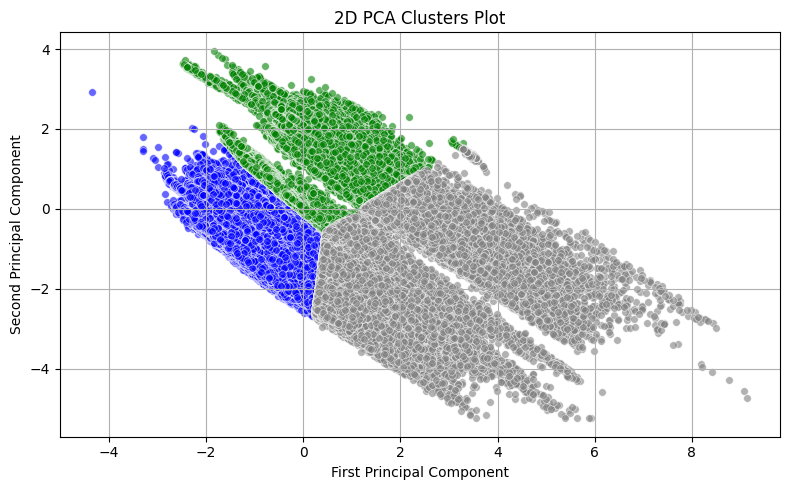

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(reduced_data)
plot_clusters(reduced_data, kmeans.labels_, 3)

From the visualization, K-means did not perform well, because the shape of the clusters are not spherical (as K-Means assumes).

We can try out other clustering algorithms that can handle arbitrary shapes clusters such as:
- DBSCAN
- Hierarchical Clustering
- Gaussian Mixture Model (GMM)

DBSCAN and AgglomerativeClustering are not feasible for the dataset of this size. They both require high computational resources. GMM has been shown to work quite well with flat-shape cluster

Gaussian Mixture Model

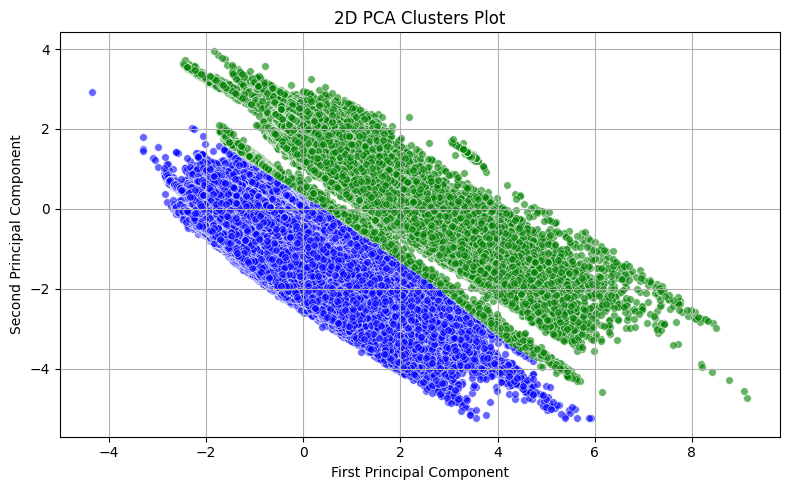

In [25]:
# Apply Gaussian Mixture Model with 2 components (clusters)
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full')
cluster_labels = gmm.fit_predict(reduced_data)

plot_clusters(reduced_data, cluster_labels, 2)

#### Analyzing clusters

In [26]:
data['cluster'] = cluster_labels
clustered = data.drop(columns=['index'])
clustered.head(2)

,id,activity,sector,loan_amount,term_in_months,lender_count,days_fully_funded,repayment_interval,mpi_value,cluster
0,653051,Fruits & Vegetables,Food,300.0,12.0,12,16.087870,irregular,0.233167,0
1,653053,Rickshaw,Transportation,575.0,11.0,14,16.053738,irregular,0.233167,0


In [42]:
clustered.groupby('cluster')[['loan_amount', 'term_in_months', 'lender_count', 'days_fully_funded']].mean()

,loan_amount,term_in_months,lender_count,days_fully_funded
cluster,,,,
0,597.434477,14.229142,18.165649,29.590621
1,450.078515,10.655423,12.169286,26.942207


In [44]:
clustered.groupby(['cluster', 'repayment_interval'])['id'].count().unstack()

repayment_interval,bullet,irregular,monthly,weekly
cluster,,,,
0,2012.0,614.0,244090.0,602.0
1,48631.0,222336.0,NaN,NaN


On average, cluster_0 shows higher figures across all variables, it also connect with the trait in repayment_interval. A loan with more money, more lenders requires longer time to fully funded and longer and more fixed repayment_interval

In [27]:
df = clustered.groupby(['sector', 'cluster'])['id'].count().unstack()
df.columns = ['cluster_0', 'cluster_1']
df['sum'] = df['cluster_0'] + df['cluster_1']
df.sort_values(by='sum', ascending=False).head(50)

,cluster_0,cluster_1,sum
sector,,,
Agriculture,73601,66918,140519
Food,68168,40784,108952
Retail,69305,32844,102149
Services,13105,18892,31997
Personal Use,7489,24489,31978
Housing,7946,17550,25496
Clothing,11395,11986,23381
Education,4501,13547,18048
Transportation,5947,6162,12109


#### Recommendation
For a disbused loan, check the most similar loan within a cluster, then recommend the subsectors that others have borrowed

In [28]:
clustered

,id,activity,sector,loan_amount,term_in_months,lender_count,days_fully_funded,repayment_interval,mpi_value,cluster
0,653051,Fruits & Vegetables,Food,300.0,12.0,12,16.087870,irregular,0.233167,0
1,653053,Rickshaw,Transportation,575.0,11.0,14,16.053738,irregular,0.233167,0
2,653063,Embroidery,Arts,200.0,11.0,8,8.208333,irregular,0.233167,0
3,653084,Milk Sales,Food,400.0,14.0,16,15.471424,monthly,0.233167,1
4,1080148,Services,Services,250.0,4.0,6,-0.477674,irregular,0.209375,0
...,...,...,...,...,...,...,...,...,...,...
518280,1340256,Livestock,Agriculture,25.0,13.0,1,0.766181,monthly,0.233167,1
518281,1340251,Livestock,Agriculture,25.0,13.0,1,2.244236,monthly,0.209375,1
518282,1340267,Livestock,Agriculture,25.0,13.0,1,1.255197,monthly,0.233167,1
518283,1340279,Livestock,Agriculture,25.0,13.0,1,3.239074,monthly,0.209375,1


In [65]:
recommend_data = clustered.copy().set_index('id')
cosine_data = pd.DataFrame(reduced_data, index=recommend_data.index)

from sklearn.metrics.pairwise import cosine_distances
def recommendation(target_id):
    target_activity = recommend_data.loc[target_id, 'activity']
    recommend_id = recommend_data[recommend_data['activity']!=target_activity].index
    target_value = cosine_data.loc[target_id].values
    recommend_value = cosine_data.loc[recommend_id].values
    distance_matrix = cosine_distances(recommend_value, [target_value])
    distance_df = pd.DataFrame(distance_matrix, index=recommend_id)
    recommend_idx = distance_df.sort_values(by=0, ascending=False).head(5).index
    recommend_activity = recommend_data.loc[recommend_idx, 'activity'].values
    print('Recommended activities:')
    for i in recommend_activity:
        print(f"- {i}")

In [66]:
recommendation(1340256)

Recommended activities:
- Farming
- Cattle
- Agriculture
- Renewable Energy Products
- Grocery Store
